In [1]:
import numpy as np
from numpy import diff
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt

#Some plot settings
import matplotlib as mpl
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 20
mpl.rcParams['text.usetex'] = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# smoothing filter
from scipy.signal import savgol_filter

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_988/3922867230.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
xSC_1 = []
xSC_2 = []
xSC_3 = []
c_rho =[]
slope_vect = []
xiv_vect = []
xSC_1_p = []
xSC_2_p = []
xSC_3_p = []

# shell borders until x = 10 
xi = np.linspace(0,1,1000)**(1/1)* 15
# shell centers
xic = 0.5*(xi[1:]+xi[:-1])
# INITIAL density profile, parameter rho0 is the central density
# Normalised to rho_DM_average (i.e. we need rho_i(r->inf)=1)

def rho_i_1(xi,rho0,xi_v):
    return (1 - (1-rho0)*np.exp(-(xi-xi_v)**2))
def dMdxi_i_1(xi,rho0,xi_v):
    return (4*np.pi*xi**2) * rho_i_1(xi,rho0,xi_v)

def rho_i_2(xi,rho0,xi_v):
    return (1 - (1-rho0)*np.exp(-(xi-xi_v)))
def dMdxi_i_2(xi,rho0,xi_v):
    return (4*np.pi*xi**2) * rho_i_2(xi,rho0,xi_v)

def rho_i_3(xi,rho0,xi_v,slope):
    return (1 - (1-rho0)/(1+np.exp(slope*(xi-xi_v-3)))) 
def dMdxi_i_3(xi,rho0,xi_v):
    return (4*np.pi*xi**2) * rho_i_3(xi,rho0,xi_v,slope)

def itera(P,R,Dx,x,bMT):
    # P, R, MT are the values of P,R, bar M_T for each shell
    a = x*(x+1)-(1+3*x/2)*Dx/2
    b = x*(x+1)+(1+3*x/2)*Dx/2
    aP = P*a/b - Dx/b * 1/2 * (bMT/R**2-R)
    return aP, R + aP*Dx

def bMT(xi,m_xi,R,verbose=0):
    # mass inside boundary i
    bMT= xi*0 
    ii = np.arange(len(m_xi))
    boundaries = np.abs(xi*R)
    # lower un upper boundary
    b0 = boundaries[:-1]
    b1 = boundaries[1:]
    # check every boundary over boundaries
    for i in range(1,len(xi)):
        pb = boundaries[i]
        b0inm = (b0<=pb)
        b1inm = (b1<=pb)
        bMT[i] = m_xi[ np.logical_and(b0inm,b1inm)].sum()    #add all shells with both boundaries inside
        # crossed shells computed apart
        parti = bMT[i]/(4*np.pi*xi[i]**3/3)
        mm = np.logical_or(np.logical_and(b0inm,~b1inm),np.logical_and(~b0inm,b1inm))
        collection = ii[mm]
        if verbose>0 and len(collection)>0:
            print('i %d collecti0n '%(i),collection,parti)
        for shell in collection:
            # calculate mass inside boundary i assuming constant density in shell
            # m_i = int rho 4pi r^2 dr = bbb (r1^3-r0^3)
            # m_i_inside is bbb (pb^3-min(r0,r1)^3) = m_i (pb^3-min(r0,r1)^3)/abs((r1^3-r0^3))
            mshellinside= m_xi[shell] * (pb**3-min(b0[shell],b1[shell])**3)/np.abs(b0[shell]**3-b1[shell]**3)
            if verbose>0:
                print('i %d shell %d, %.2f/%.2f b0 %f b1 %f'%(i,shell,mshellinside,m_xi[shell],b0[shell],b1[shell]))
            bMT[i] += mshellinside
    aux= bMT[1:]/(4*np.pi*xi**3/3)[1:]
    a2 = xi*0
    a2[1:]=aux
    a2[0]=aux[0]
    return a2

R=np.ones(len(xi))

In [3]:
def sasa(bMTla_1,Rdla_1):
    mder_1a = bMTla_1*0
    aux = np.zeros(len(bMTla_1))
    for i in range(len(bMTla_1)):
        mder_1a[i]=np.gradient(bMTla_1[i],xi*Rdla_1[i])
        aux[i] = mder_1a[i].max()
    #plt.loglog(xla_1,aux,'.-')
    crit = (aux[1:]-aux[:-1])/(aux[1:])
    #plt.loglog(xla_1[1:],crit)
    #Javier's method
    #inn = np.argmax(crit)
    #My method
    inn = np.argmax(crit)
    for i in range(len(crit)-1):
        if crit[i]>0.95 and crit[i]>crit[i+1] and crit[i]>crit[i-1]:
            inn = i
            break
    #print(xla_1[inn])
    return xla_1[inn]
    #plt.axvline(x=xla_1[inn], color='k', linestyle='--', label=r'$x_{sc} = %.2f$'%xla_1[inn])
    #print(crit)
    #plt.xlabel(r'$x=a/a_{\rm eq}$');plt.ylabel(r'$[d\bar{M}_{T}/d(\xi R)]_{max}$')
    #plt.legend(prop={'size': 14})


In [5]:
# central density and radius
rho0, xi_v = 0.1, 0
contador = 0

for slopedex in [3]:#range(1,41,4):

    slope = slopedex
    
    # shell mass
    m_xi_1 = xic*0
    m_xi_2 = xic*0
    m_xi_3 = xic*0

    for i in range(len(xi)-1):
        m_xi_1[i] = quad(dMdxi_i_1, xi[i], xi[i+1],args=(rho0, xi_v))[0]
        m_xi_2[i] = quad(dMdxi_i_2, xi[i], xi[i+1],args=(rho0, xi_v))[0]
        m_xi_3[i] = quad(dMdxi_i_3, xi[i], xi[i+1],args=(rho0, xi_v))[0]
    
    # Define arrays
    x = 1e-3
    Rd_1  = R
    Pd_1  = R*0
    Rd_2  = R
    Pd_2  = R*0
    Rd_3  = R
    Pd_3  = R*0
    bMTd_1 = bMT(xi,m_xi_1,Rd_1)
    bMTd_2 = bMT(xi,m_xi_2,Rd_2)
    bMTd_3 = bMT(xi,m_xi_3,Rd_3)
    Rdl_1 = []
    Pdl_1 = []
    bMTl_1 = []
    xl_1  = []
    Rdl_2 = []
    Pdl_2 = []
    bMTl_2 = []
    xl_2  = []
    Rdl_3 = []
    Pdl_3 = []
    bMTl_3 = []
    xl_3  = []

    # Evolve
    para      = 6
    it_number = 140 * para
    dxpar     = 10  * para
    ditsave   = 1   * para
    for i in range(it_number):
        Dx = x/dxpar #variar esto
        Pd_1, Rd_1 = itera(Pd_1,Rd_1,Dx,x,bMTd_1)
        Pd_2, Rd_2 = itera(Pd_2,Rd_2,Dx,x,bMTd_2)
        Pd_3, Rd_3 = itera(Pd_3,Rd_3,Dx,x,bMTd_3)
        bMTd_1 = bMT(xi,m_xi_1,Rd_1)
        bMTd_2 = bMT(xi,m_xi_2,Rd_2)
        bMTd_3 = bMT(xi,m_xi_3,Rd_3)
        x=x+Dx
        if i%ditsave == 0:
            Pdl_1.append(Pd_1)
            Rdl_1.append(Rd_1)
            bMTl_1.append(bMTd_1)
            xl_1.append(x)
            Pdl_2.append(Pd_2)
            Rdl_2.append(Rd_2)
            bMTl_2.append(bMTd_2)
            xl_2.append(x)
            Pdl_3.append(Pd_3)
            Rdl_3.append(Rd_3)
            bMTl_3.append(bMTd_3)
            xl_3.append(x)
    Pdla_1=np.array(Pdl_1)
    Rdla_1=np.array(Rdl_1)
    bMTla_1=np.array(bMTl_1)
    xla_1= np.array(xl_1)
    Pdla_2=np.array(Pdl_2)
    Rdla_2=np.array(Rdl_2)
    bMTla_2=np.array(bMTl_2)
    xla_2= np.array(xl_2)
    Pdla_3=np.array(Pdl_3)
    Rdla_3=np.array(Rdl_3)
    bMTla_3=np.array(bMTl_3)
    xla_3= np.array(xl_3)

    # SECOND CRITERIA

    G_1 = bMTla_1*0
    Gp_1 = bMTla_1*0
    G_2 = bMTla_2*0
    Gp_2 = bMTla_2*0
    G_3 = bMTla_3*0
    Gp_3 = bMTla_3*0

    G_1 = (bMTla_1-1) * xi**2
    Gp_1 = np.gradient(G_1,xi,axis=1)
    G_2 = (bMTla_2-1) * xi**2
    Gp_2 = np.gradient(G_2,xi,axis=1)
    G_3 = (bMTla_3-1) * xi**2
    Gp_3 = np.gradient(G_3,xi,axis=1)

    # Calculate x_caustic for each shell

    Gsc_1 = Gp_1/(2*xi) #Gsc is the function find maximum
    Gsc_max_1 = xla_1*0 
    x_sc_1 = xla_1*0

    Gsc_2 = Gp_2/(2*xi) #Gsc is the function find maximum
    Gsc_max_2 = xla_2*0 
    x_sc_2 = xla_2*0

    Gsc_3 = Gp_3/(2*xi) #Gsc is the function find maximum
    Gsc_max_3 = xla_3*0 
    x_sc_3 = xla_3*0

    for i1 in range(len(xla_1)):
        for j1 in range(len(xic)-1):
            if j1!=0 and Gsc_1[i1][j1] > Gsc_1[i1][j1-1] and Gsc_1[i1][j1] > Gsc_1[i1][j1+1]:
                Gsc_max_1[i1] = Gsc_1[i1][j1]

    for i2 in range(len(xla_2)):
        for j2 in range(len(xic)-1):
            if j2!=0 and Gsc_2[i2][j2] > Gsc_2[i2][j2-1] and Gsc_2[i2][j2] > Gsc_2[i2][j2+1]:
                Gsc_max_2[i2] = Gsc_2[i2][j2]

    for i in range(len(xla_3)):
        for j in range(len(xic)-1):
            if j!=0 and Gsc_3[i][j] > Gsc_3[i][j-1] and Gsc_3[i][j] > Gsc_3[i][j+1]:
                Gsc_max_3[i] = Gsc_3[i][j]


    x_sc_1 = 1/Gsc_max_1
    #print(Gsc_max_1[0])
    #print(x_sc_1[0]) #x_sc for initial time
    x_sc_2 = 1/Gsc_max_2
    #print(Gsc_max_2[0])
    #print(x_sc_2[0]) #x_sc for initial time
    x_sc_3 = 1/Gsc_max_3
    #print(Gsc_max_3[0])
    #print(x_sc_3[0]) #x_sc for initial time

    xSC_1.append(x_sc_1[0])
    xSC_2.append(x_sc_2[0])
    xSC_3.append(x_sc_3[0])
    #c_rho.append(rho0)
    slope_vect.append(slope)
    #xiv_vect.append(xi_v)
    
    #INFINITE SLOPE
    
    xSC_1_p.append(sasa(bMTla_1,Rdla_1))
    xSC_2_p.append(sasa(bMTla_2,Rdla_2))
    xSC_3_p.append(sasa(bMTla_3,Rdla_3))

    contador = contador + 1
    print(contador)
    
#print(c_rho)
#print(xSC_1)
#print(xSC_2)
#print(xSC_3)


/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_956/855637991.py:101: RuntimeWarning: divide by zero encountered in divide
  Gsc_1 = Gp_1/(2*xi) #Gsc is the function find maximum
/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_956/855637991.py:105: RuntimeWarning: divide by zero encountered in divide
  Gsc_2 = Gp_2/(2*xi) #Gsc is the function find maximum
/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_956/855637991.py:109: RuntimeWarning: divide by zero encountered in divide
  Gsc_3 = Gp_3/(2*xi) #Gsc is the function find maximum


1


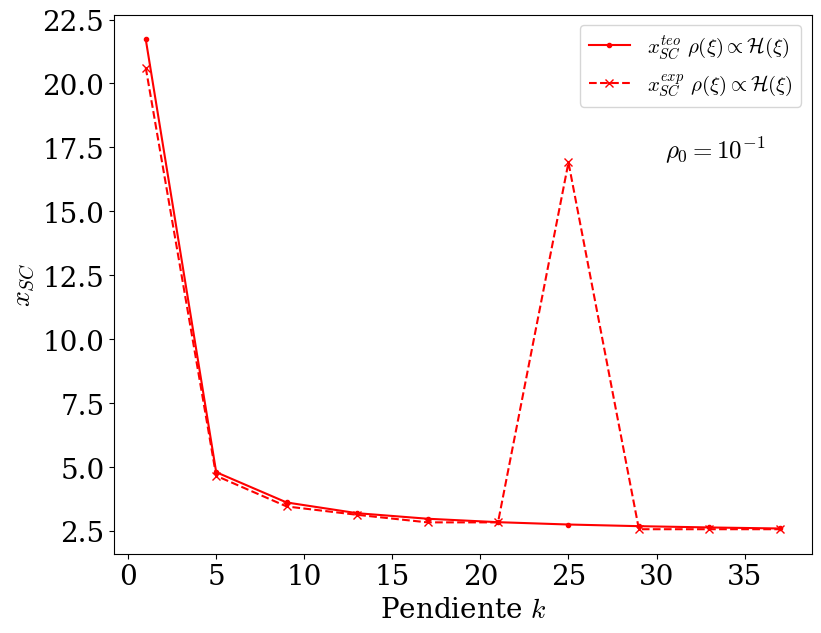

In [51]:
#Plot
fig,ax=plt.subplots(1,1,figsize=(9,7))

#ax.plot(slope_vect,xSC_1,'x-',label=r'$\rho(\xi)\propto e^{-\xi^2}$; $\xi_v = %.0f$'%xi_v)
#ax.plot(slope_vect,xSC_2,'rx-',label=r'$\rho(\xi)\propto e^{-\xi}$; $\xi_v = %.0f$'%xi_v)
ax.plot(slope_vect,xSC_3,'r.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')
ax.plot(slope_vect,xSC_3_p,'rx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

tex = r'$\rho_0=10^{-1}$'
ax.text(30.5,18.0,tex,fontsize=18,horizontalalignment='left',verticalalignment='top')

ax.set_xlabel(r'Pendiente $k$');ax.set_ylabel(r'$x_{SC}$')

#ax.plot(c_rho,(1-c_rho)*np.exp(c_rho),'k--')

ax.legend(fontsize=15)

#plt.savefig('xSCvsK.pdf')
#print(slope_vect)

In [52]:
#np.save('xSC_1rho.npy', xSC_1);np.savetxt('xSC_1rho.txt', xSC_1)
#np.save('xSC_2rho.npy', xSC_2);np.savetxt('xSC_2rho.txt', xSC_2)
#np.save('xSC_3rho.npy', xSC_3);np.savetxt('xSC_3rho.txt', xSC_3)
#np.save('xSC_1_prho.npy', xSC_1_p);np.savetxt('xSC_1_prho.txt', xSC_1_p)
#np.save('xSC_2_prho.npy', xSC_2_p);np.savetxt('xSC_2_prho.txt', xSC_2_p)
#np.save('xSC_3_prho.npy', xSC_3_p);np.savetxt('xSC_3_prho.txt', xSC_3_p)
#np.save('c_rho.npy',c_rho);np.savetxt('c_rho.txt',c_rho)

#np.save('xSC_1xiv.npy', xSC_1);np.savetxt('xSC_1xiv.txt', xSC_1)
#np.save('xSC_2xiv.npy', xSC_2);np.savetxt('xSC_2xiv.txt', xSC_2)
#np.save('xSC_3xiv.npy', xSC_3);np.savetxt('xSC_3xiv.txt', xSC_3)
#np.save('xSC_1_pxiv.npy', xSC_1_p);np.savetxt('xSC_1_pxiv.txt', xSC_1_p)
#np.save('xSC_2_pxiv.npy', xSC_2_p);np.savetxt('xSC_2_pxiv.txt', xSC_2_p)
#np.save('xSC_3_pxiv.npy', xSC_3_p);np.savetxt('xSC_3_pxiv.txt', xSC_3_p)
#np.save('xiv_vect.npy',xiv_vect);np.savetxt('xiv_vect.txt',xiv_vect)

np.save('xSC_3k.npy', xSC_3);np.savetxt('xSC_3k.txt', xSC_3)
np.save('xSC_3_pk.npy', xSC_3_p);np.savetxt('xSC_3_pk.txt', xSC_3_p)
np.save('slope_vect.npy',slope_vect);np.savetxt('slope_vect.txt',slope_vect)

18.674881432227465
91.2855375551123
6.27294193796814


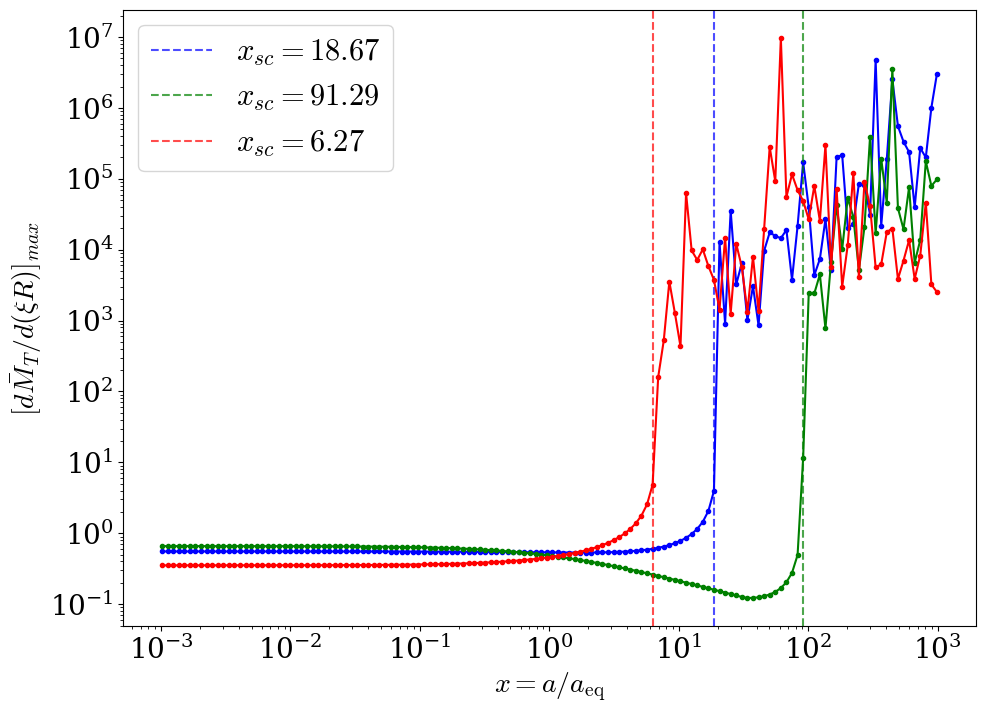

In [29]:
mpl.rcParams['font.size'] = 20
plt.figure(figsize=(11,8))
def sasa(bMTla_1,Rdla_1,col):
    mder_1a = bMTla_1*0
    aux = np.zeros(len(bMTla_1))
    for i in range(len(bMTla_1)):
        mder_1a[i]=np.gradient(bMTla_1[i],xi*Rdla_1[i])
        aux[i] = mder_1a[i].max()
    plt.loglog(xla_1,aux,'.-', color=col)
    crit = (aux[1:]-aux[:-1])/(aux[1:])
    #plt.loglog(xla_1[1:],crit)
    #Javier's method
    #inn = np.argmax(crit)
    #My method
    inn = 0
    for i in range(len(crit)-1):
        if crit[i]>0.95 and crit[i]>crit[i+1] and crit[i]>crit[i-1]:
            inn = i
            break
    print(xla_1[inn])
    plt.axvline(x=xla_1[inn], color=col, linestyle='--', label=r'$x_{sc} = %.2f$'%xla_1[inn], alpha=0.7)
    #print(crit)
    plt.xlabel(r'$x=a/a_{\rm eq}$');plt.ylabel(r'$[d\bar{M}_{T}/d(\xi R)]_{max}$')
    plt.legend(prop={'size': 22})
    
sasa(bMTla_1,Rdla_1,'b')
sasa(bMTla_2,Rdla_2,'g')
sasa(bMTla_3,Rdla_3,'r')
#plt.savefig('mdermax.pdf')

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(22,7))
#for i in [0,-50,-40,-30,-21,-17,-5,-1]:
for i in [1]:
    ax[0].plot(xi*Rdla_1[i],bMTla_1[i])
    ax[0].plot(xi*Rdla_1[i],mder_1[i])
#     ax[0].plot(xi*Rdla_1[i],mder_1a[i])
#     aux = np.gradient(bMTla_1[i],xi,axis=0)
#     ax[1].plot(xi*Rdla_2[i],aux)
    ax[1].plot(xi*Rdla_2[i],bMTla_2[i])
    ax[1].plot(xi*Rdla_2[i],mder_2[i])
#     ax[1].plot(xi*Rdla_2[i],mder_2a[i])    
    ax[2].plot(xi*Rdla_3[i],bMTla_3[i])
    ax[2].plot(xi*Rdla_3[i],mder_3[i])    

ax[0].set_ylim(0,5)
ax[1].set_ylim(0,5) 
#for i in [100,150,180,200,220,250]:
 #   ax.plot(xla_1,mder_1[:,i])
#xla_1.shape
#bMTla_1.shape
#aux1 = np.argmax(mder_1,axis=0,keepdims=True)
#print(aux1)
xSC_1_p = 0
xSC_2_p = 0
xSC_3_p = 0
mder_1max = np.amax(mder_1)
mder_2max = np.amax(mder_2)
mder_3max = np.amax(mder_3)

from numpy import unravel_index
indtup_1=unravel_index(mder_1.argmax(),mder_1.shape)
xSC_1_p = xla_1[indtup_1[0]]
indtup_2=unravel_index(mder_2.argmax(),mder_2.shape)
xSC_2_p = xla_2[indtup_2[0]]
indtup_3=unravel_index(mder_3.argmax(),mder_3.shape)
xSC_3_p = xla_3[indtup_3[0]]

print(indtup_1)
print(mder_1max)
print(xSC_1_p)
print(indtup_2)
print(mder_2max)
print(xSC_2_p)
print(indtup_3)
print(mder_3max)
print(xSC_3_p)

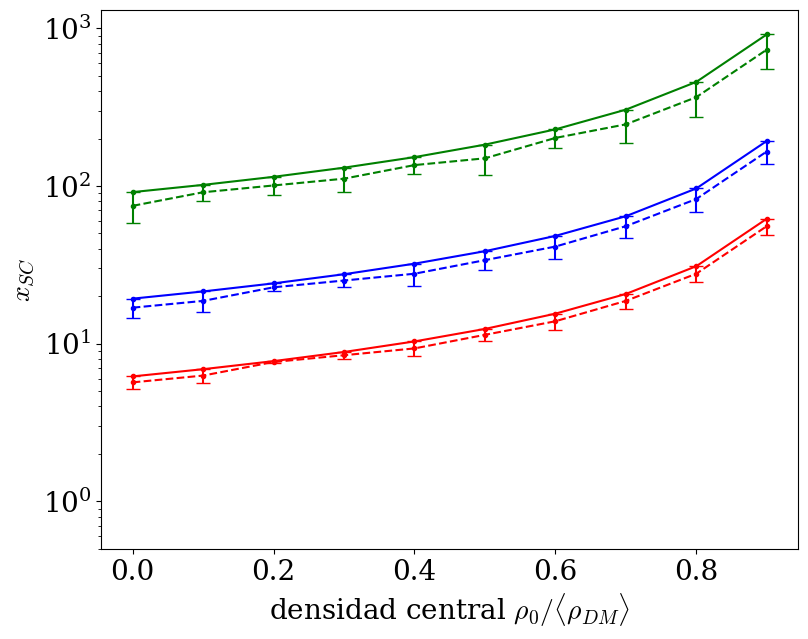

In [24]:
# Replot de xSC vs rho0

c_rho=np.load('npyarrays/c_rho.npy')
xSC_1=np.load('npyarrays/xSC_1rho.npy')
xSC_2=np.load('npyarrays/xSC_2rho.npy')
xSC_3=np.load('npyarrays/xSC_3rho.npy')
xSC_1_p=np.load('npyarrays/xSC_1_prho.npy')
xSC_2_p=np.load('npyarrays/xSC_2_prho.npy')
xSC_3_p=np.load('npyarrays/xSC_3_prho.npy')

fig,ax=plt.subplots(1,1,figsize=(9,7))

ax.semilogy(c_rho,xSC_1,'b.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto e^{-\xi^2}$')
ax.semilogy(c_rho,xSC_2,'g.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto e^{-\xi}$')
ax.semilogy(c_rho,xSC_3,'r.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

serror1 = np.abs(xSC_1-xSC_1_p)
serror2 = np.abs(xSC_2-xSC_2_p)
serror3 = np.abs(xSC_3-xSC_3_p)
ax.errorbar(c_rho,xSC_1_p, yerr=serror1,fmt='b.--', ecolor='b', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi^2}$')
ax.errorbar(c_rho,xSC_2_p, yerr=serror2,fmt='g.--', ecolor='g', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi}$')
ax.errorbar(c_rho,xSC_3_p, yerr=serror3,fmt='r.--', ecolor='r', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

#ax.plot(c_rho,xSC_1_p,'bx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi^2}$')
#ax.plot(c_rho,xSC_2_p,'gx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi}$')
#ax.plot(c_rho,xSC_3_p,'rx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

ax.set_xlabel(r'densidad central $\rho_0/\langle\rho_{DM}\rangle$');ax.set_ylabel(r'$x_{SC}$')

#ax.legend(fontsize=13)

#plt.savefig('xSCvsrho0errors.pdf')

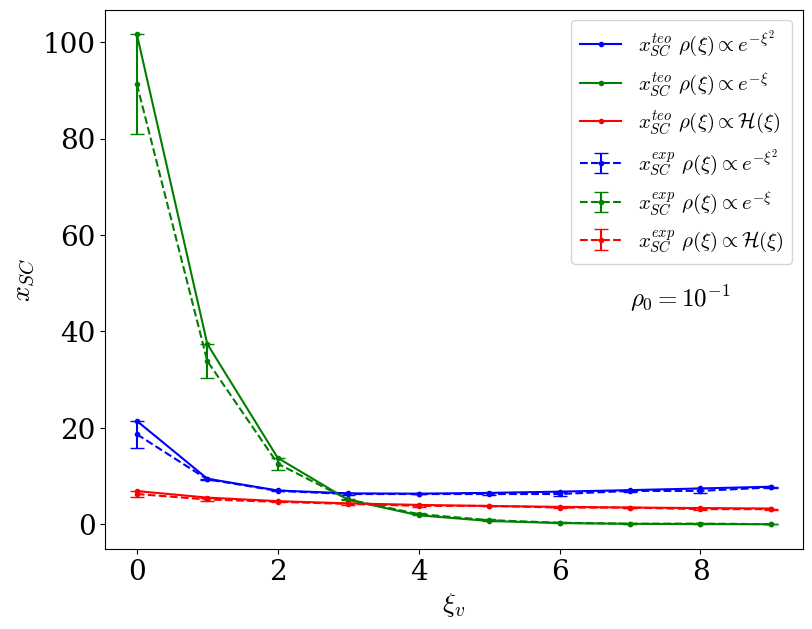

In [22]:
# Replot xSC vs xiv

xiv_vect = np.load('npyarrays/xiv_vect.npy')
xSC_1 = np.load('npyarrays/xSC_1xiv.npy')
xSC_2 = np.load('npyarrays/xSC_2xiv.npy')
xSC_3 = np.load('npyarrays/xSC_3xiv.npy')
xSC_1_p = np.load('npyarrays/xSC_1_pxiv.npy')
xSC_2_p = np.load('npyarrays/xSC_2_pxiv.npy')
xSC_3_p = np.load('npyarrays/xSC_3_pxiv.npy')


fig,ax=plt.subplots(1,1,figsize=(9,7))

ax.plot(xiv_vect,xSC_1,'b.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto e^{-\xi^2}$')
ax.plot(xiv_vect,xSC_2,'g.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto e^{-\xi}$')
ax.plot(xiv_vect,xSC_3,'r.-',label=r'$x_{SC}^{teo}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

serror1 = np.abs(xSC_1-xSC_1_p)
serror2 = np.abs(xSC_2-xSC_2_p)
serror3 = np.abs(xSC_3-xSC_3_p)
ax.errorbar(xiv_vect,xSC_1_p, yerr=serror1,fmt='b.--', ecolor='b', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi^2}$')
ax.errorbar(xiv_vect,xSC_2_p, yerr=serror2,fmt='g.--', ecolor='g', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi}$')
ax.errorbar(xiv_vect,xSC_3_p, yerr=serror3,fmt='r.--', ecolor='r', capsize=5, label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')

#ax.plot(xiv_vect,xSC_1_p,'bx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi^2}$')
#ax.plot(xiv_vect,xSC_2_p,'gx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto e^{-\xi}$')
#ax.plot(xiv_vect,xSC_3_p,'rx--',label=r'$x_{SC}^{exp}$ $\rho(\xi)\propto \mathcal{H}(\xi)$')


tex = r'$\rho_0=10^{-1}$'
ax.text(7.0,50.0,tex,fontsize=18,horizontalalignment='left',verticalalignment='top')

ax.set_xlabel(r'$\xi_v$');ax.set_ylabel(r'$x_{SC}$')

#ax.plot(c_rho,(1-c_rho)*np.exp(c_rho),'k--')

ax.legend(fontsize=15)

#plt.savefig('xSCvsXiVerrors.pdf')

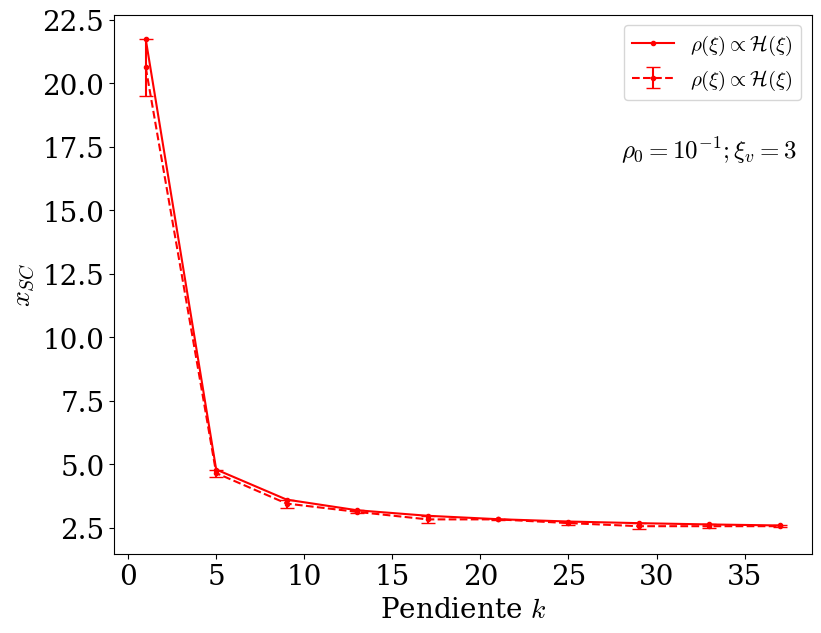

In [32]:
# Replot  xSC vs pendiente

slope_vect = np.load('npyarrays/slope_vect.npy')
xSC_3 = np.load('npyarrays/xSC_3k.npy')
xSC_3_p = np.load('npyarrays/xSC_3_pk.npy')

fig,ax=plt.subplots(1,1,figsize=(9,7))

#ax.plot(slope_vect,xSC_1,'x-',label=r'$\rho(\xi)\propto e^{-\xi^2}$; $\xi_v = %.0f$'%xi_v)
#ax.plot(slope_vect,xSC_2,'rx-',label=r'$\rho(\xi)\propto e^{-\xi}$; $\xi_v = %.0f$'%xi_v)
serror3 = np.abs(xSC_3-xSC_3_p)
ax.plot(slope_vect,xSC_3,'r.-',label=r'$\rho(\xi)\propto \mathcal{H}(\xi)$')
ax.errorbar(slope_vect,xSC_3_p,yerr=serror3,fmt='r.--', ecolor='r', capsize=5,label=r'$\rho(\xi)\propto \mathcal{H}(\xi)$')

tex = r'$\rho_0=10^{-1} ; \xi_v = 3$'
ax.text(28.0,18.0,tex,fontsize=18,horizontalalignment='left',verticalalignment='top')

ax.set_xlabel(r'Pendiente $k$');ax.set_ylabel(r'$x_{SC}$')

#ax.plot(c_rho,(1-c_rho)*np.exp(c_rho),'k--')

ax.legend(fontsize=15)

#plt.savefig('xSCvsKerrors.pdf')